<a href="https://colab.research.google.com/github/Cloud-Course-Group-Phoenix/Project-Pheonix/blob/Or_Gilad_tirgul/Tirgul7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests beautifulsoup4
!pip install firebase



In [2]:
DBLink = "ENTER YOUR DB LINK HERE"


In [4]:
url = 'https://en.wikipedia.org/wiki/One_Piece'

In [13]:
queries = 'one OR piece Or luffy Or pirate and oda and  release and anime and fruit and manga or japan'

{'one': 313, 'piec': 293, 'luffi': 23, 'pirat': 45, 'oda': 65, 'releas': 41, 'anim': 165, 'fruit': 14, 'manga': 194, 'japan': 45}
1.0


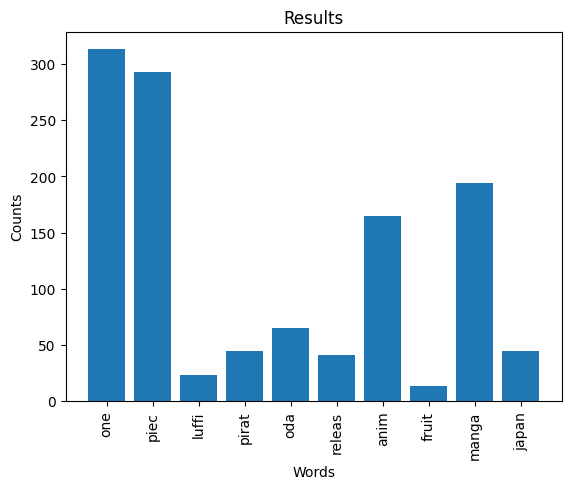

In [15]:
import requests
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from firebase import firebase
import matplotlib.pyplot as plt

class DbService:
    def __init__(self,Dblink):
        self.dbLink= Dblink

    def insert_to_db(self,results):
        FBconn = firebase.FirebaseApplication(self.dbLink,None)
        FBconn.put('/','found_words_from_query',results)

    def get_from_db(self):
        FBconn = firebase.FirebaseApplication(self.dbLink,None)
        results = FBconn.get('/','found_words_from_query')
        return results


class QueryService:
    def __init__(self,url):
        self.url = url

    def fetch_page(self):
        response = requests.get(self.url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            return soup
        else:
            return None

    def index_words(self,soup):
        index = {}
        words = re.findall(r'\w+', soup.get_text())
        for word in words:
            word = word.lower()
            if word in index:
                index[word] += 1
            else:
                index[word] = 1
        return index

    def remove_stop_words(self,index):
      stop_words = {'a', 'an', 'the', 'and', 'or','in', 'on', 'at'}
      for stop_word in stop_words:
        if stop_word in index:
          del index[stop_word]
      return index

    def apply_stemming(self,index):
      stemmer = PorterStemmer()
      stemmed_index = {}
      for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
          stemmed_index[stemmed_word] += count
        else:
          stemmed_index[stemmed_word] = count
      return stemmed_index

    def search(self,query, index):
      stemmer = PorterStemmer()
      query_words = re.findall(r'\w+', query.lower())
      results = {}
      for word in query_words:
        word = stemmer.stem(word)
        if word in index:
          results[word] = index[word]
      return results


class RankService:
    def __init__(self):
        pass

    def rank(self,results):
        rank=1
        for word, count in results.items():
          rank = rank*1/count
        rank = 1-rank
        return rank


class PlotService:
    def __init__(self):
        pass
    def plot_bar_chart(self,results):
      # create a bar chart showing the number of appearences of each of the 10 words with set spacing between the words to make it readable
      words = list(results.keys())
      counts = list(results.values())
      plt.bar(words, counts)
      plt.xticks(rotation=90)
      plt.xlabel('Words')
      plt.ylabel('Counts')
      plt.title('Results')
      plt.show()


def main():
  dbService = DbService(DBLink)
  queryService = QueryService(url)
  rankService = RankService()
  plotService = PlotService()
  soup = queryService.fetch_page()
  index = queryService.index_words(soup)
  index = queryService.remove_stop_words(index)
  index = queryService.apply_stemming(index)
  results = queryService.search(queries, index)
  dbService.insert_to_db(results)
  rank = rankService.rank(results)
  print(results)
  print(rank)
  plotService.plot_bar_chart(results)


if __name__ == '__main__':

  main()

